# Principle modelling

## wavelength scale
$\lambda^\mathrm{r}=k_{\mathrm{\lambda\ m-c}}\bullet\left(\lambda_\mathrm{s}+\lambda_{\mathrm{a-c}}+\lambda_{\mathrm{a-uc}}+\lambda_{\mathrm{a-f}}\right)$

## value scale
$S^\mathrm{r}=S_\mathrm{s}\bullet k_{\mathrm{Sm-f}}\bullet k_{\mathrm{Sm-c}}\bullet\left(1+S_{\mathrm{a-c}}+S_{\mathrm{a-uc}}+S_{\mathrm{a-f}}\right)$



In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel, StatDataVector
import pandas as pd
from empir19nrm02.tools import sumMC, sumMCV

import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, _CMF

out_dir = 'MCSim_PM'

wl = lx.getwlr([360,830,5])
NumberTrials = 10000
# Number of base functions (as a hack with pos/neg number of base functions to select the type...)
# >0 use sin/cos base functions
# <0 use chebyshev base functions
N_Fourier = -7
maxOutElements = 5
lambda0 = 555

import os
print( 'CWD:', os.getcwd())

marker = ['-', '--', '-.',':', '.', 'o', '-', '--','-.',':','.']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c']

CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


# Make some very first MCS

In [2]:
# define some input data (as MCVar to make an analysis after the run)
T0 = 3000
mcT = MCVar(name=NameUnit('T', 'K'), distribution=DistributionParam(mean=T0,stddev=1., distribution='normal'))

# wavelength
mcLambda_a_c = MCVar(name=NameUnit('lambda_a_c', 'nm'), distribution=DistributionParam(mean=0.,stddev=1., distribution='normal'))

mcLambda_a_uc = MCVectorVar(name=NameUnit('lambda_a_uc', 'nm'), elements=len(wl))
mcLambda_a_uc.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

mcLambda_a_f = MCVectorVar(name=NameUnit('lambda_a_f', 'nm'), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 1, distribution = 'normal', add_params = N_Fourier)})
mcLambda_a_f.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

mcLambda_m_c = MCVar(name=NameUnit('lambda_m_c', 'nm'), distribution=DistributionParam(mean=1.,stddev=0.001, distribution='normal'))

# Signal
mcS_a_c = MCVar(name=NameUnit('S_a_c', ''), distribution=DistributionParam(mean=0.,stddev=0.01, distribution='normal'))

mcS_a_uc = MCVectorVar(name=NameUnit('S_a_uc', ''), elements=len(wl))
mcS_a_uc.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_a_f = MCVectorVar(name=NameUnit('S_a_f', ''), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_a_f.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_c = MCVar(name=NameUnit('S_m_c', ''), distribution=DistributionParam(mean=1.,stddev=0.01, distribution='normal'))

mcS_m_f = MCVectorVar(name=NameUnit('S_m_f', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_m_f.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))


# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['Y','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wl))

# define some basic data needed inside the MCS

kBB = 1./(lx.spd_to_xyz(lx.blackbody(T0, wl, relative=False))[0][1])

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# simple model calculating the photometric integral from the photometers
def model_L0( T, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_c, S_a_c, S_a_uc, S_a_f, S_m_c, S_m_f):
    wl_mod = Lambda_m_c*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    # using the manipulated wl-scale for calculation of the bb
    bb = lx.blackbody(T, wl_mod, relative=False)
    # reconstruct the nominal one
    bb_mod = bb.copy()
    bb_mod[0] = wl
    bb_mod[1] *= kBB
    bb_mod[1] = bb_mod[1]*S_m_f*S_m_c*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(bb_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    return [Yxy[0], CCT, duv, bb_mod[1]]

input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_c, mcS_m_f]
output = [mcYxy, mcCCT, mcDuv, mcSpectrum]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_L0)

res_data = sim.get_result_db()
res_data


Generate:


,index,Input,,Mean,StdDev,Distr,Add_Param,Y,u(Y),x,u(x),y,u(y),CCT,u(CCT),Duv,u(Duv)
0,0,T,,3000,1.0,normal,None,1.000011,0.002799,0.436932,0.000071,0.404069,0.000024,2999.988521,0.994358,-0.000002,0.0
1,0,lambda_a_c,,0.0,1.0,normal,None,0.999946,0.00612,0.436939,0.000569,0.404071,0.000243,2999.915437,7.612036,-0.000002,0.000019
2,0,lambda_a_uc,,0.0,1.0,normal,None,1.000001,0.001149,0.43693,0.000229,0.404068,0.000268,3000.014956,3.914911,-0.000002,0.000103
3,0,lambda_a_f,f_add,0,1,normal,-7,1.000001,0.004047,0.436931,0.000694,0.404068,0.000766,3000.026575,12.066871,-0.000002,0.0003
4,0,lambda_m_c,,1.0,0.001,normal,None,0.999954,0.003444,0.436936,0.000213,0.40407,0.000073,2999.945598,2.999712,-0.000002,0.0
5,0,S_a_c,,0.0,0.01,normal,None,1.0,0.009968,0.436933,0.0,0.40407,0.0,2999.985669,0.000594,-0.000002,0.0
6,0,S_a_uc,,0.0,0.01,normal,None,1.0,0.001877,0.436932,0.000325,0.404069,0.000297,2999.993677,6.4397,-0.000002,0.000135
7,0,S_a_f,f_add,0,0.01,normal,-7,1.0,0.00651,0.436931,0.000976,0.404069,0.000868,3000.064008,19.430151,-0.000001,0.0004
8,0,S_m_c,,1.0,0.01,normal,None,1.000062,0.010112,0.436933,0.0,0.40407,0.0,2999.985663,0.0,-0.000002,0.0
9,0,S_m_f,f_mul,0,0.01,normal,-7,1.0001,0.006494,0.436931,0.000973,0.404069,0.000865,3000.062109,19.26576,-0.000001,0.000396


In [3]:
def get_name(i:int)->str:
    return res_data['Input'][i]

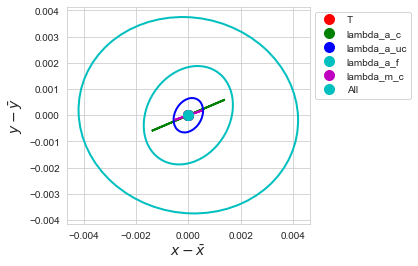

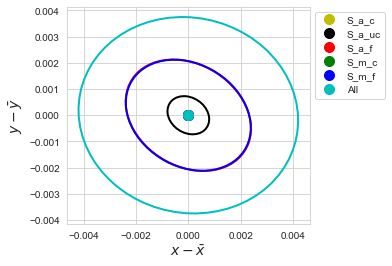

In [4]:
ax = None
len_part1 = 5
index_end = len(input)

for i in [*range(len_part1), index_end]:
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_lambda_all')

ax = None
for i in range(len_part1, len(input)+1):
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_S_all')

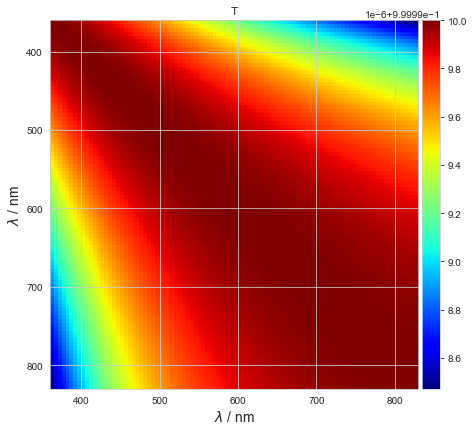

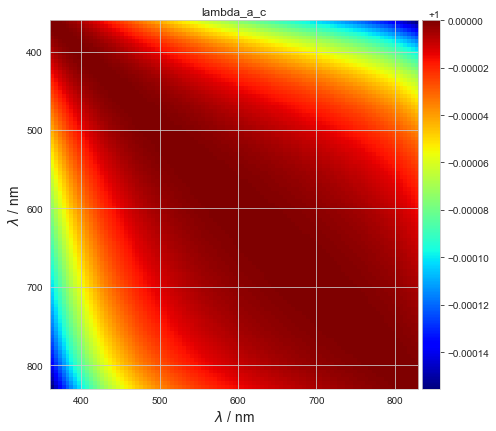

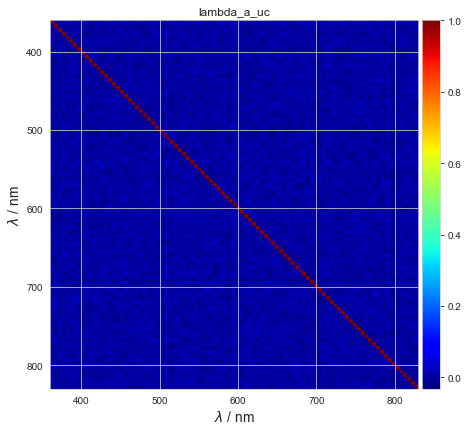

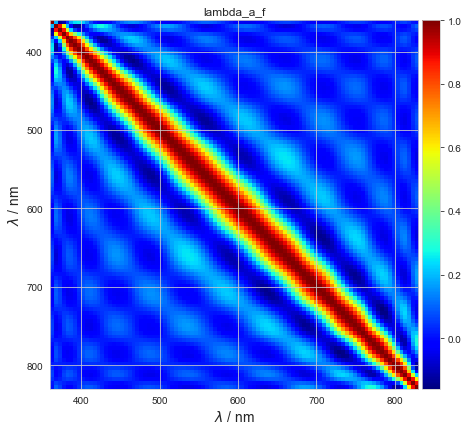

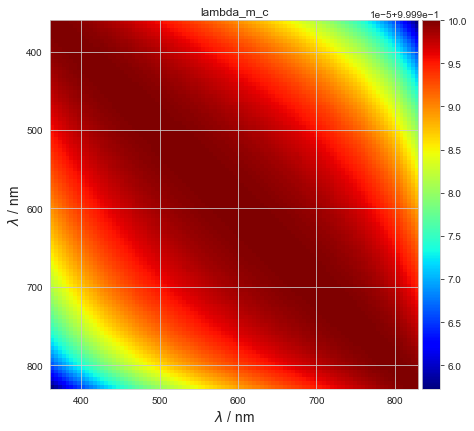

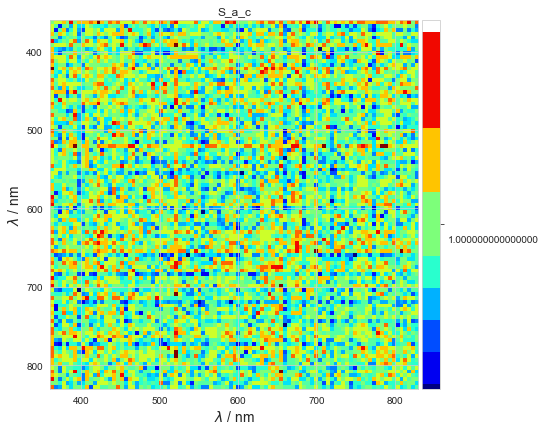

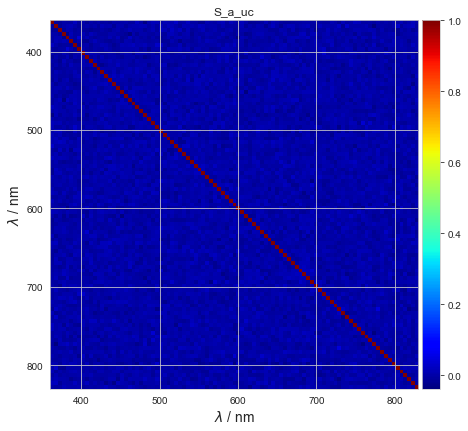

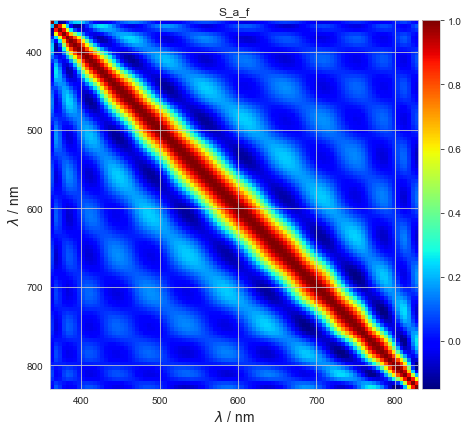

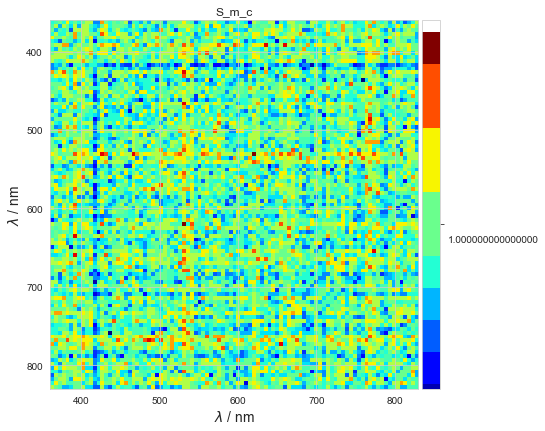

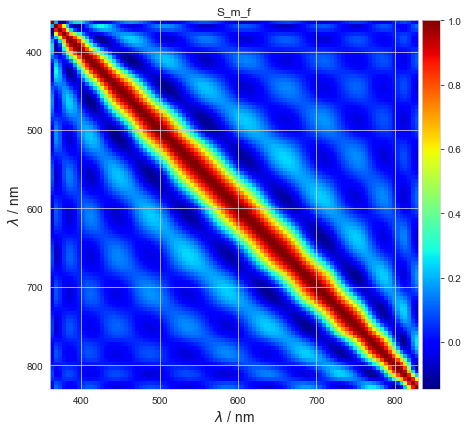

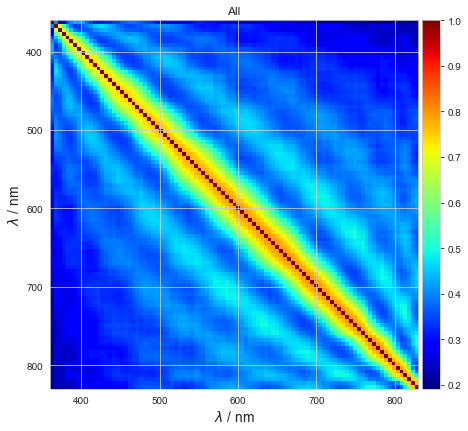

In [5]:
for i in range(len(input)+1):
    var = sim.output_var[i]
    var[-1].calc_cov_matrix_from_data()
    plotCorrelation(var[-1].runData.corr_matrix, wl, get_name(i))
    save_fig(out_dir, 'DataCorr_'+get_name(i))


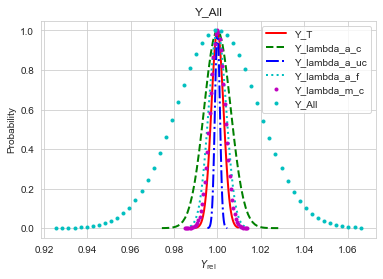

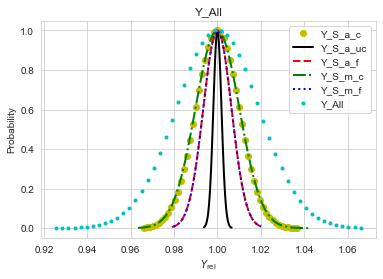

In [6]:
#display some histograms
ax1 = None
for i in [*range(len_part1), index_end]:
    var = sim.output_var[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True)
save_fig(out_dir, 'HistYxy_Yrel_Lambda')

ax1 = None
for i in range(len_part1, index_end+1):
    var = sim.output_var[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True)
save_fig(out_dir, 'HistYxy_Yrel_S')


Value= [1.0, 0.00279885457550779] Inteval(95%)= 0.01093554755675663


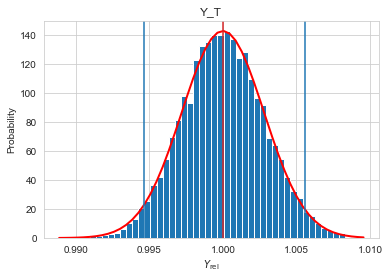

Value= [1.0, 0.00612014118609041] Inteval(95%)= 0.024007545717676826


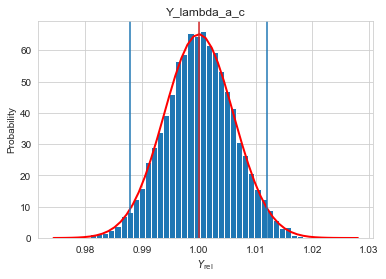

Value= [1.0, 0.0011487246875326448] Inteval(95%)= 0.004458918379308008


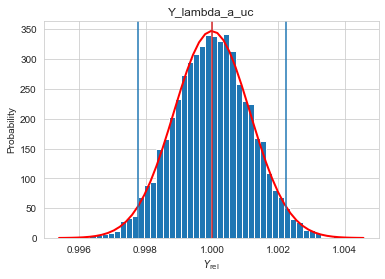

Value= [1.0, 0.004047447088345453] Inteval(95%)= 0.015462329794922458


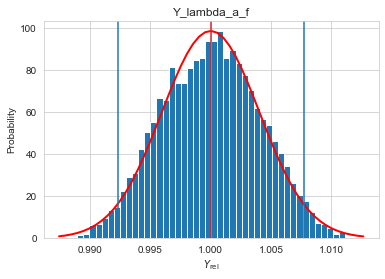

Value= [0.9999999999999998, 0.0034444181926607084] Inteval(95%)= 0.013408848494598224


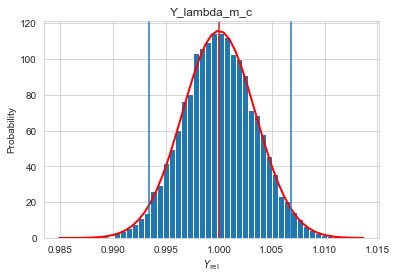

Value= [1.0, 0.009968319613355722] Inteval(95%)= 0.03902115156780006


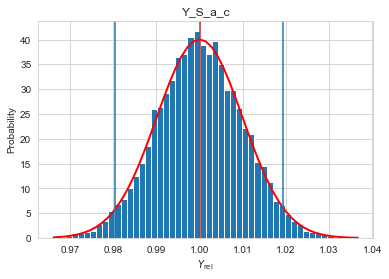

Value= [1.0, 0.0018773481941737414] Inteval(95%)= 0.007383900386744857


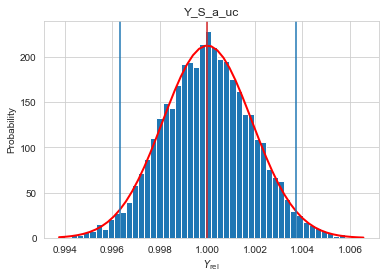

Value= [1.0, 0.006509771010586565] Inteval(95%)= 0.02480332479736702


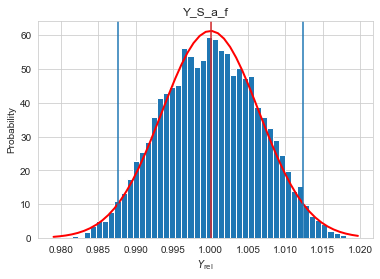

Value= [1.0, 0.010111817181962626] Inteval(95%)= 0.03941403099775054


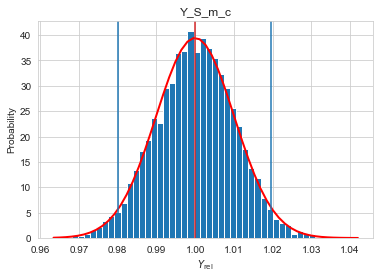

Value= [0.9999999999999998, 0.006493352185016769] Inteval(95%)= 0.024835801306604566


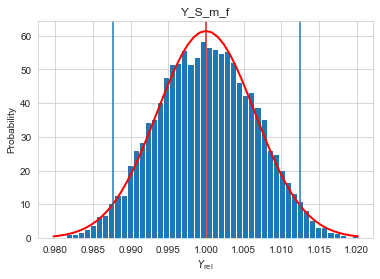

Value= [0.9999999999999998, 0.01906983025706285] Inteval(95%)= 0.07431124794129618


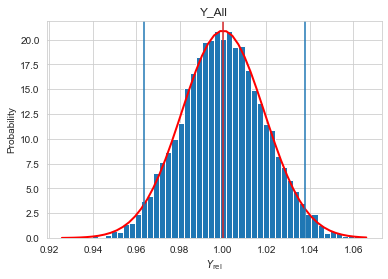

In [7]:
#display some histograms
for i in range(len(input)+1):
    var = sim.output_var[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$')
    save_fig(out_dir, 'HistYxy_Yrel_'+get_name(i))

In [8]:
var = sim.output_var[0]
column_str_MC= [var[0].name.get_name_unit(0)[0], var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0], var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0]]
for i in range(len(input)+1):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    print('Input_Var:', get_name(i))
    norm_data = pd.concat([pd.DataFrame(var[0].val[:,0]/np.mean(var[0].val[:,0])), pd.DataFrame(var[0].val[:,1]), pd.DataFrame(var[0].val[:,2]), pd.DataFrame(cct.val), pd.DataFrame(duv.val)], axis=1)
    norm_data.columns = column_str_MC
    print( norm_data.corr())

Input_Var: T
            Y         x         y       CCT       Duv
Y    1.000000 -0.999998 -0.999999  0.999999 -0.993223
x   -0.999998  1.000000  1.000000 -1.000000  0.993435
y   -0.999999  1.000000  1.000000 -1.000000  0.993351
CCT  0.999999 -1.000000 -1.000000  1.000000 -0.993397
Duv -0.993223  0.993435  0.993351 -0.993397  1.000000
Input_Var: lambda_a_c
            Y         x         y       CCT       Duv
Y    1.000000 -0.999994 -0.999999  1.000000 -0.999999
x   -0.999994  1.000000  0.999989 -0.999996  0.999998
y   -0.999999  0.999989  1.000000 -0.999998  0.999996
CCT  1.000000 -0.999996 -0.999998  1.000000 -0.999999
Duv -0.999999  0.999998  0.999996 -0.999999  1.000000
Input_Var: lambda_a_uc
            Y         x         y       CCT       Duv
Y    1.000000 -0.108142  0.470650  0.369888  0.520008
x   -0.108142  1.000000  0.260124 -0.841774 -0.034758
y    0.470650  0.260124  1.000000  0.302278  0.955950
CCT  0.369888 -0.841774  0.302278  1.000000  0.568760
Duv  0.520008 -0.034758 

In [9]:
import seaborn as sns
def get_data_step(size_to_minimize, max_data_to_display=1000):
    if size_to_minimize < max_data_to_display:
        step = 1
        disp_count = size_to_minimize
    else:
        step = int(size_to_minimize / max_data_to_display)
        disp_count = int(size_to_minimize / step)
    return disp_count, step


In [10]:
def seaborn_plot_result_gen(loc_result, display = [1,0,0], dim=3, column_str = [], title=''):
    disp_array_count, step = get_data_step(loc_result.shape[1])
    disp_array = np.zeros((dim, disp_array_count - 1))
    print( loc_result[:,0])
    for i in range(disp_array_count - 1):
        for j in range(dim):
            match display[j]:
                case 0 | 'n' | 'none':   disp_array[j, i] = loc_result[j, i * step + 1]
                case 1 | 'r' | 'rel':    disp_array[j, i] = loc_result[j, i * step + 1] / loc_result[j, 0]
                case 2 | 'd' | 'diff':   disp_array[j, i] = loc_result[j, i * step + 1] - loc_result[j, 0]
                case _: print('Display kind', display[j], ' not supported')

    sns.set_theme(style="ticks")
    column_str_loc = column_str.copy()
    for j in range(dim):
        match display[j]:
            case 0 | 'n' | 'none':   column_str_loc[j] = '$'+ column_str_loc[j] + '$'
            case 1 | 'r' | 'rel':    column_str_loc[j] = '$'+ column_str_loc[j] + '_{\mathrm{rel}}$'
            case 2 | 'd' | 'diff':   column_str_loc[j] = '$'+ '\Delta ' + column_str_loc[j] + '$'
            case _: print('Display kind', display[j], ' not supported')

    df = pd.DataFrame(data=disp_array.T, columns=column_str_loc)
    grid = sns.pairplot(df, corner=True)
    plotTitle = title

    grid.fig.suptitle(plotTitle.format())

Input_Var: T
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


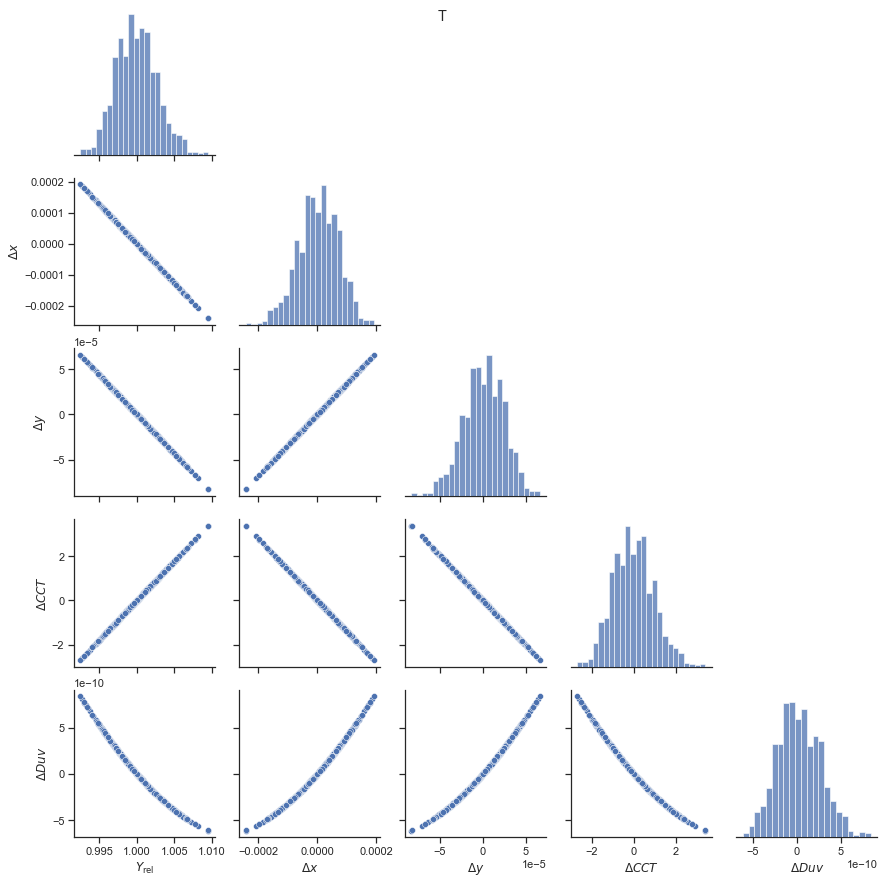

Input_Var: lambda_a_c
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


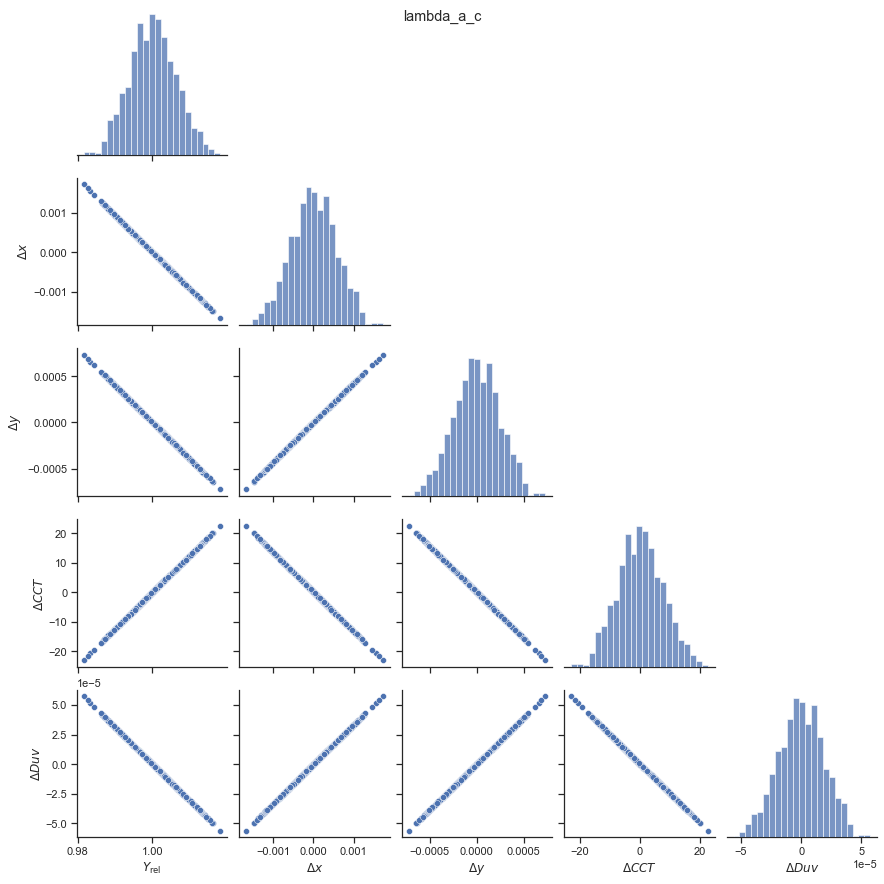

Input_Var: lambda_a_uc
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


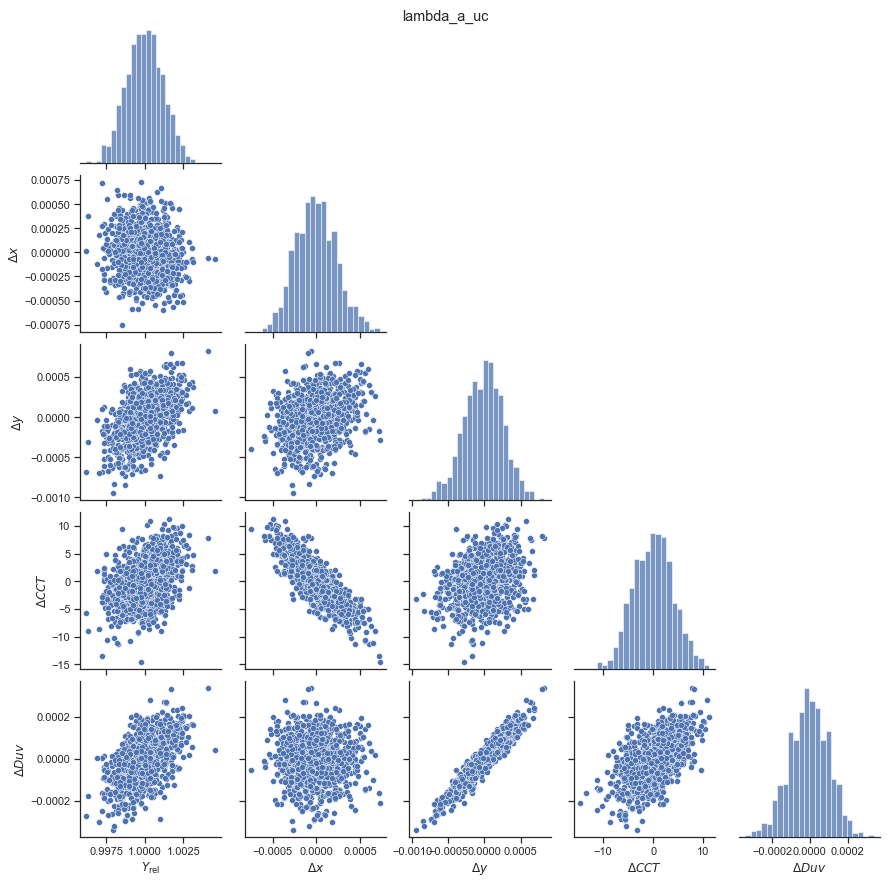

Input_Var: lambda_a_f
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


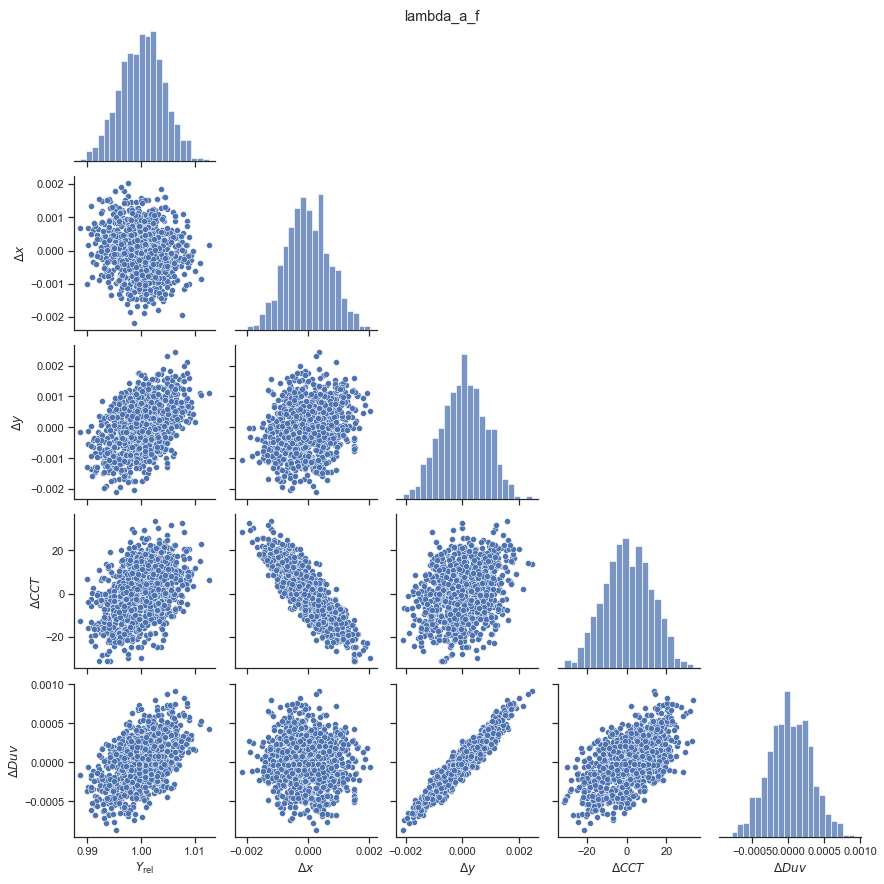

Input_Var: lambda_m_c
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


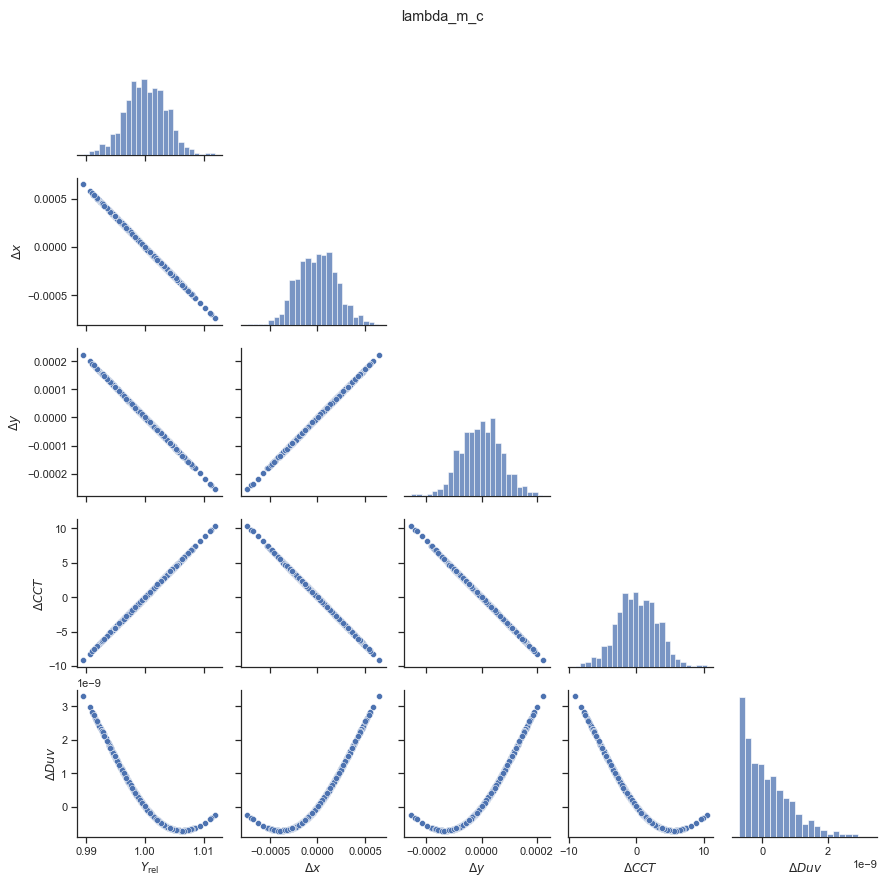

Input_Var: S_a_c
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


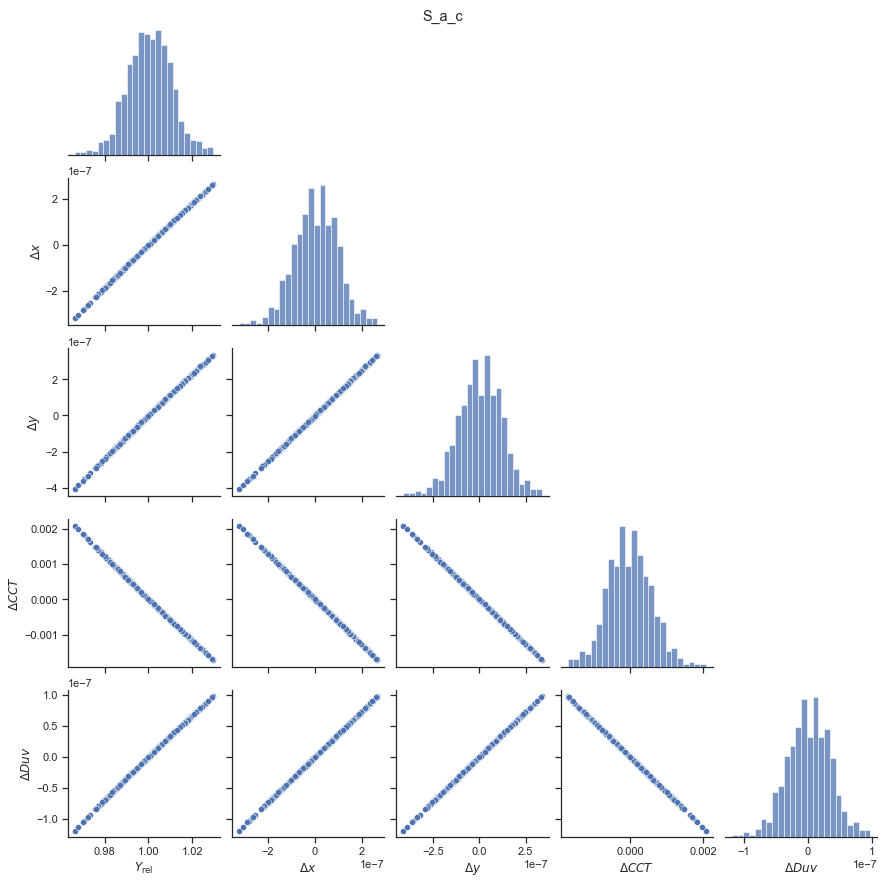

Input_Var: S_a_uc
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


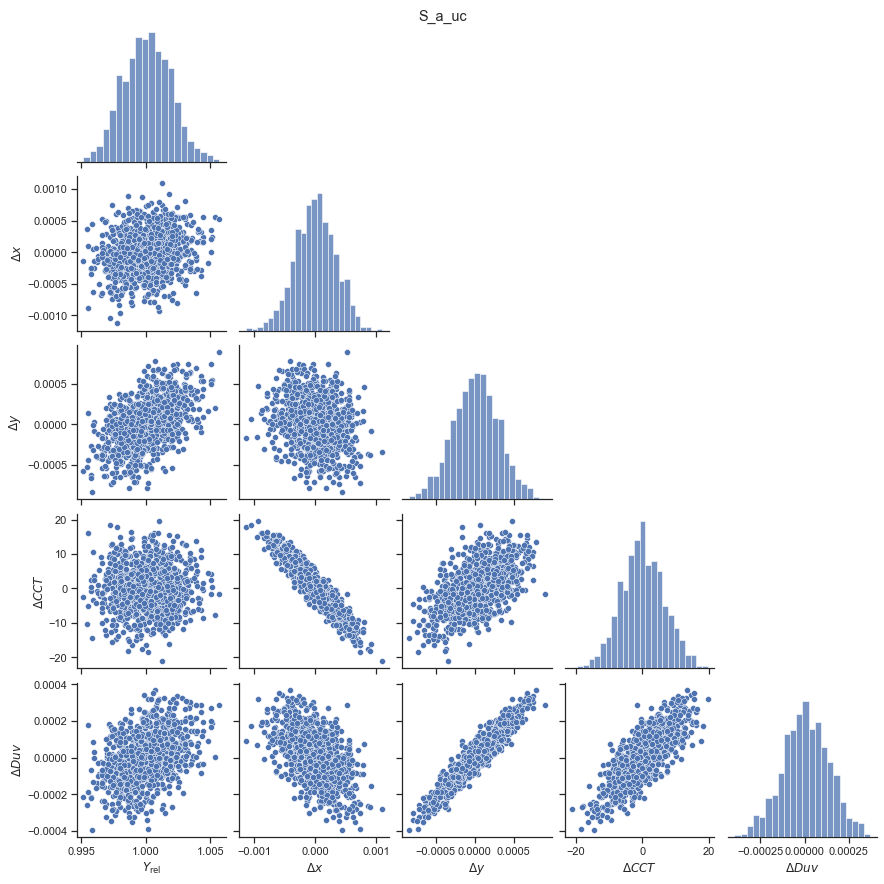

Input_Var: S_a_f
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


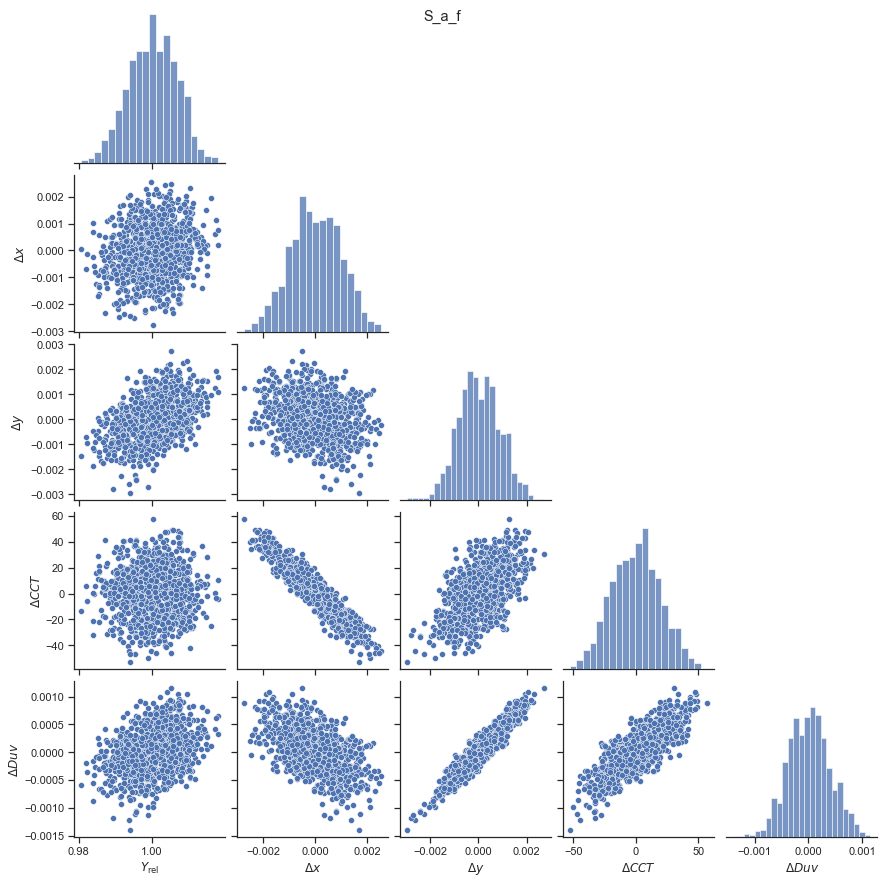

Input_Var: S_m_c
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


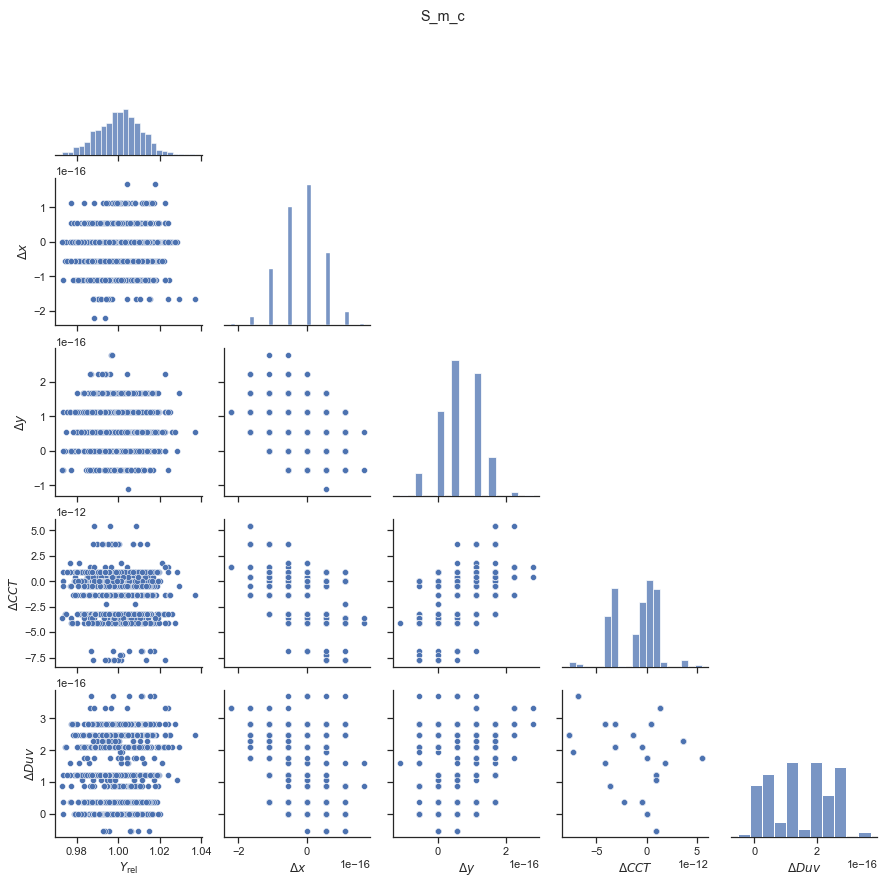

Input_Var: S_m_f
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


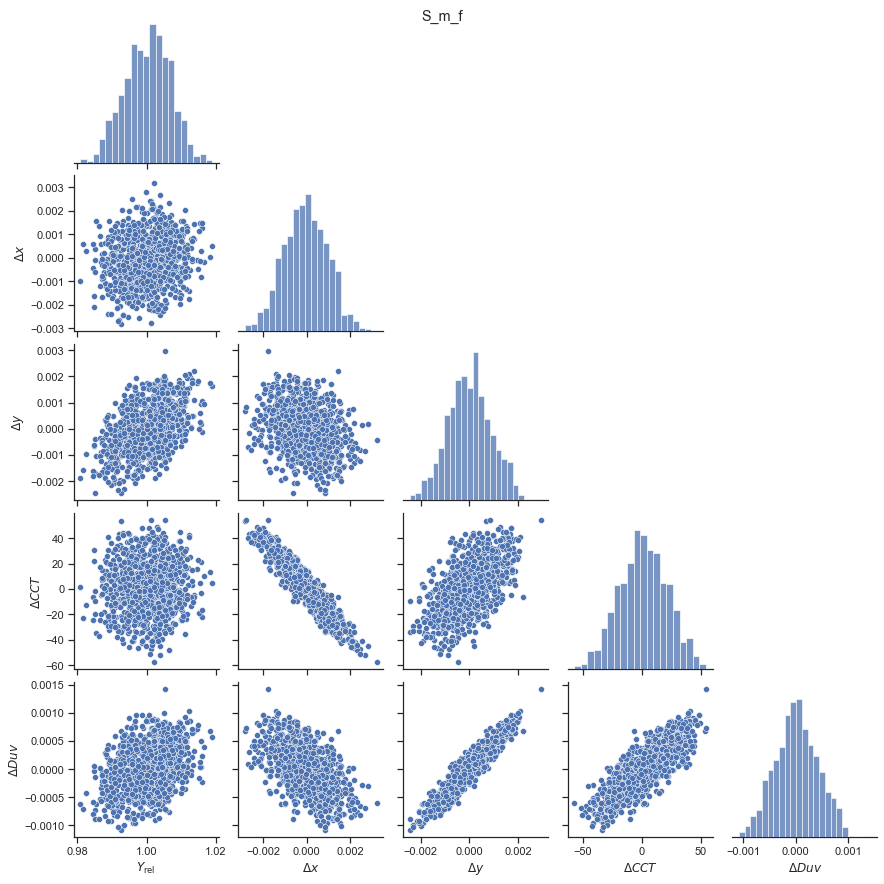

Input_Var: All
[1.0000e+00 4.3693e-01 4.0407e-01 3.0000e+03 -1.9874e-06]


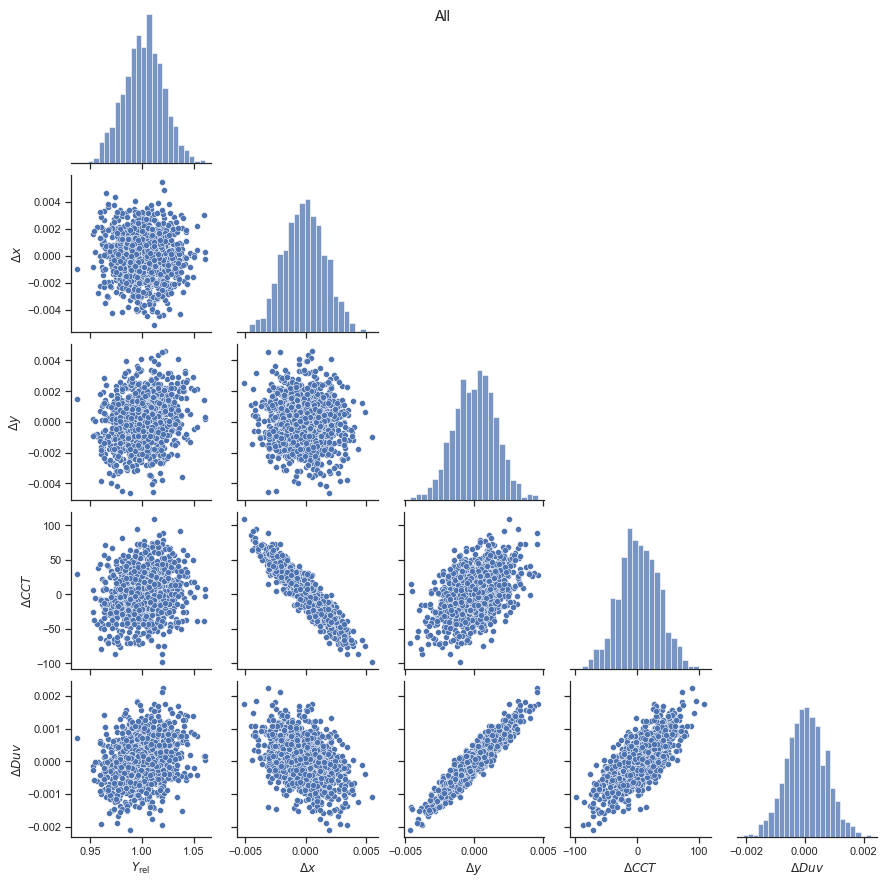

In [11]:
for i in range(len(input)+1):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    print('Input_Var:', get_name(i))
    seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, duv.val.T)), display=['r','d','d','d','d'], dim=5, column_str=column_str_MC, title=get_name(i))
    save_fig(out_dir, 'Observation_YxyCCTDuv_' + get_name(i))

Generate:


,index,Input,,Mean,StdDev,Distr,Add_Param,Y,u(Y),x,u(x),y,u(y),CCT,u(CCT),Duv,u(Duv)
0,0,PTBResFEL-1000W-Lamp-1,,0.050024,0.000228,normal,None,1.0,0.004587,0.431791,0.000161,0.402751,0.000098,3077.743545,2.968506,0.000206,0.000047
1,0,All,,,,,,1.0,0.004587,0.431791,0.000161,0.402751,0.000098,3077.743545,2.968506,0.000206,0.000047


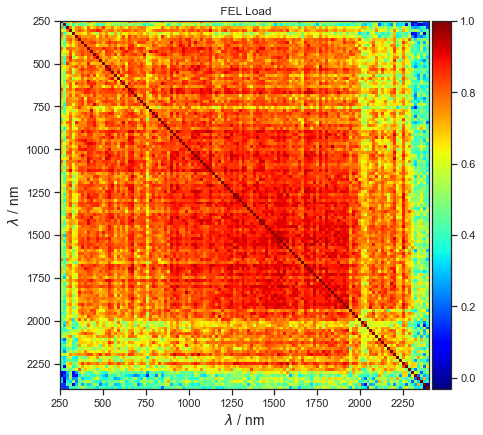

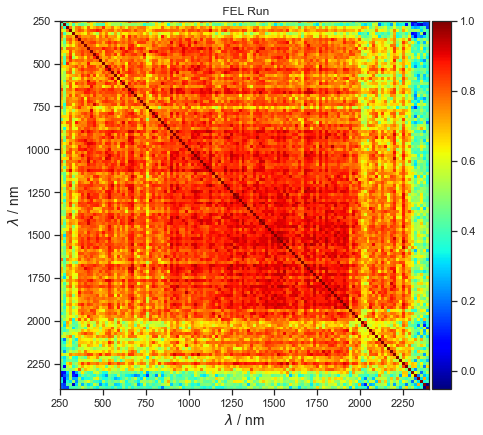

In [12]:
str_file = 'PTBResFEL-1000W-Lamp-1'
wlFEL, mcVectorVarFEL = load_from_csv('MCSim_Test/Lamps/FEL-1000W-Lamp-1/' + str_file)
mcVectorVarFEL.name = NameUnit(str_file, '')
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, ' FEL Load')

XYZ = lx.spd_to_xyz(np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean)),relative=False)
kFEL = 1./(XYZ[0][1])

# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['Y','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wlFEL))

# define some basic data needed inside the MCS

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# simple model calculating the photometric integral from the photometers
def model_LFEL( FEL):
    fel = np.vstack((wlFEL, kFEL*FEL))
    XYZ = lx.spd_to_xyz(fel, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    return [Yxy[0], CCT, duv, fel[1]]

input = [mcVectorVarFEL]
output = [mcYxy, mcCCT, mcDuv, mcSpectrum]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_LFEL)

res_data = sim.get_result_db()


mcVectorVarFEL.calc_cov_matrix_from_data()
plotCorrelation(mcVectorVarFEL.runData.corr_matrix, wlFEL, ' FEL Run')
res_data

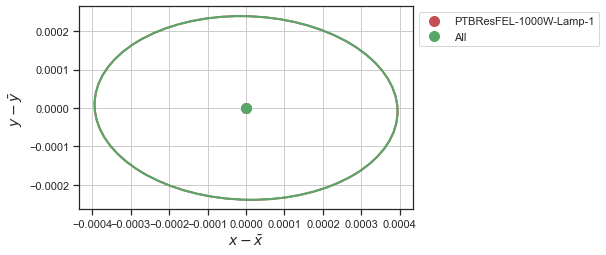

In [13]:
ax = None
for i in range(len(input)+1):
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_fel_all')

Value= [1.0000000000000002, 0.004586663674020076] Inteval(95%)= 0.018090985441980623


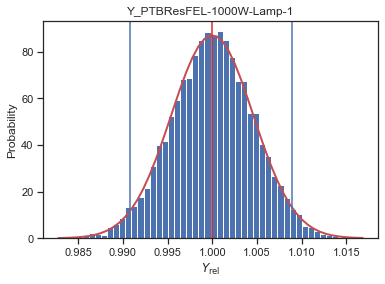

In [14]:
#display some histograms
for i in range(len(input)):
    var = sim.output_var[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$')
    save_fig(out_dir, 'HistYxy_Yrel_'+get_name(i))

Input_Var: PTBResFEL-1000W-Lamp-1
[1.0000e+00 4.3179e-01 4.0275e-01 3.0777e+03 2.0606e-04]


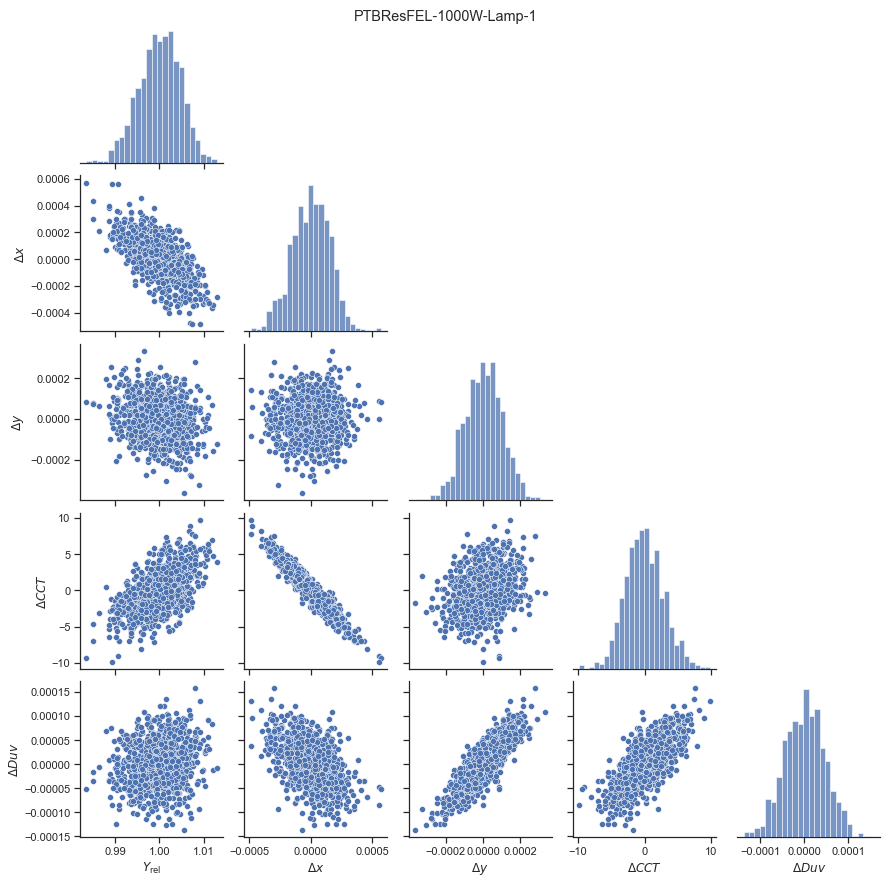

In [15]:
for i in range(len(input)):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    print('Input_Var:', get_name(i))
    seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, duv.val.T)), display=['r','d','d','d','d'], dim=5, column_str=column_str_MC, title=get_name(i))
    save_fig(out_dir, 'Observation_YxyCCTDuv_' + get_name(i))

In [16]:
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel, StatDataVector

mc1 = MCVar(name=NameUnit('V1', 'U1'), distribution=DistributionParam(mean=1.,stddev=2., distribution='normal'))
mc2 = MCVar(name=NameUnit('V2', 'U2'), distribution=DistributionParam(mean=2.,stddev=4., distribution='triangle'))
mc3 = MCVar(name=NameUnit('V3', 'U3'), distribution=DistributionParam(mean=3.,stddev=6., distribution='uniform'))

# define some output data (as MCVar to make an analysis after the run)
mcOut1 = MCVar(name=NameUnit('Plus1','UnitPlus1'))
mcOut2 = MCVar(name=NameUnit('Plus2','UnitPlus2'))
def model_easy( a, b, c):
    return [a+b, b+c]

input = [mc1, mc2, mc3]
output = [mcOut1, mcOut2]

sim = MCSimulation(trials=100000)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_easy)

print( sim.trials)
res_data = sim.get_result_db()
res_data

Generate:
100000


,index,Input,,Mean,StdDev,Distr,Add_Param,Plus1,u(Plus1),Plus2,u(Plus2)
0,0,V1,,1.0,2.0,normal,None,2.999223,1.998396,5.0,0.0
1,0,V2,,2.0,4.0,triangle,None,2.97936,3.990956,4.97936,3.990956
2,0,V3,,3.0,6.0,uniform,None,3.0,0.0,4.977581,6.000293
3,0,All,,,,,,2.978583,4.459336,4.956941,7.195082


Value= [0.9992225396485157, 1.998395702246451] Inteval(95%)= 7.865641833520446
Value= [1.979360043674725, 3.9909563525376175] Inteval(95%)= 15.22778208244614
Value= [2.977580527763364, 6.00029325621948] Inteval(95%)= 19.732790576372892


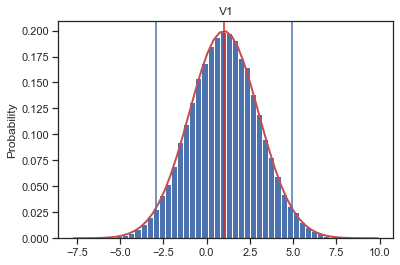

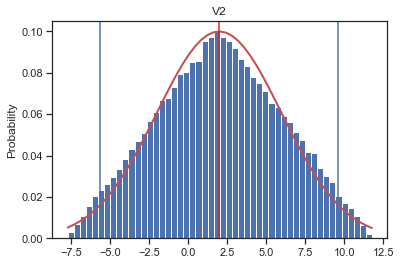

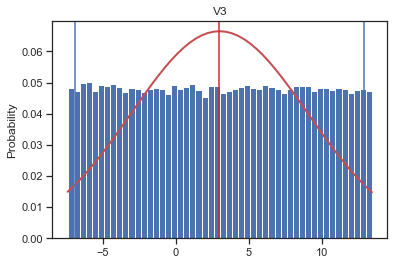

In [17]:
#display some histograms
for i in range(len(input)):
    var = sim.input_var[i]
    plotHistScales( var.val, add_distribution=True, title=get_name(i), xLabel='')


Value= [2.999222539648515, 1.998395702246451] Inteval(95%)= 7.865641833520446
Value= [5.0, 0.0] Inteval(95%)= 0.0
Value= [2.979360043674725, 3.9909563525376175] Inteval(95%)= 15.22778208244614
Value= [4.979360043674725, 3.9909563525376175] Inteval(95%)= 15.22778208244614
Value= [3.0, 0.0] Inteval(95%)= 0.0
Value= [4.977580527763363, 6.0002932562194795] Inteval(95%)= 19.732790576372892
Value= [2.97858258332324, 4.45933589893777] Inteval(95%)= 17.144304650435632
Value= [4.956940571438088, 7.195082495190973] Inteval(95%)= 27.020524964819906


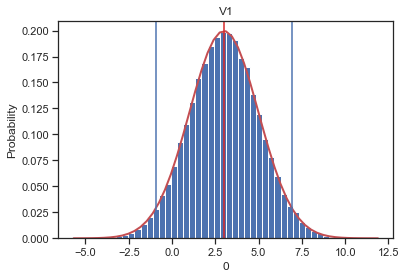

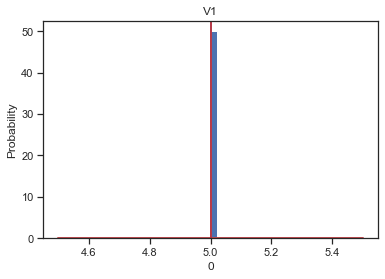

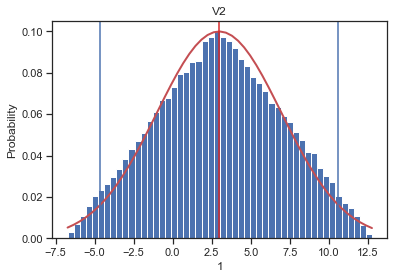

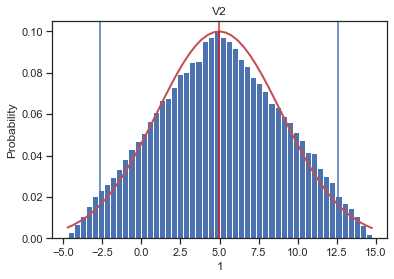

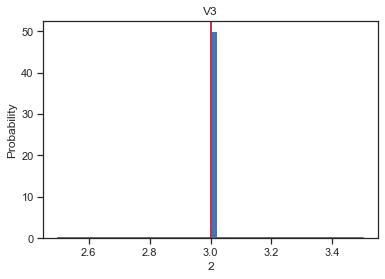

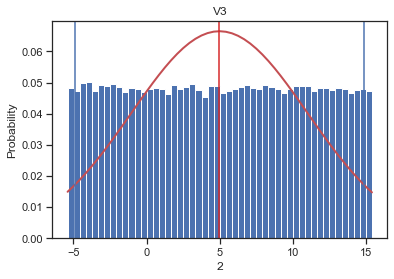

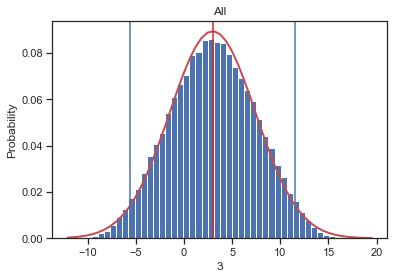

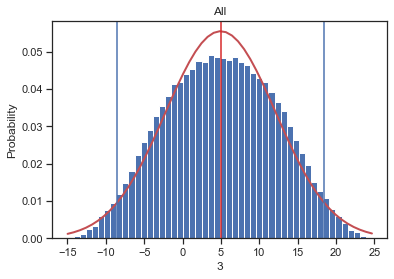

In [19]:
#display some histograms
for i in range(len(input)+1):
    var = sim.output_var[i]
    plotHistScales( var[0].val, add_distribution=True, title=get_name(i), xLabel=str(i))
    plotHistScales( var[1].val, add_distribution=True, title=get_name(i), xLabel=str(i))
